# AI6126 ACV Project 1


In [1]:
nb_ver = 0.3

## Versioning & References

### Changelogs
+ V0.1 - Setup codes to download and unzip celeba to gDrive
+ V0.2 - Added training loop 
+ V0.3 - Added seeding + save/ load checkpoint (doing)

### References
+ [PyTorch Transfer Learning](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)
+ [TWD fast.ai](https://towardsdatascience.com/real-time-multi-facial-attribute-detection-using-transfer-learning-and-haar-cascades-with-fastai-47ff59e36df0)

## Setup/ Configuration

### Colab

In [2]:
# you can choose to mount your Google Drive (optional)
import sys, os
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    file_name = f'ai6126-project1-colab-v{nb_ver}.ipynb'
    print(file_name)
    import subprocess
    path_to_file = subprocess.check_output('find . -type f -name ' + str(file_name), shell=True).decode("utf-8")
    print(path_to_file)
    path_to_file = path_to_file.replace(file_name,"").replace('\n',"")
    os.chdir(path_to_file)
    !pwd

In [3]:
# check nvcc version
!nvcc -V
# check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Wed_Oct_23_19:32:27_Pacific_Daylight_Time_2019
Cuda compilation tools, release 10.2, V10.2.89


'gcc' is not recognized as an internal or external command,
operable program or batch file.


### Download Dataset

In [4]:
import os, glob
local_download_path = '../data/celeba/img_align_celeba'
download_dataset = True
if os.path.exists(local_download_path):
    images = glob.glob(local_download_path + '/*.jpg')
    if len(images) == 202599:
        download_dataset = False
print(f"download celeba dataset: {download_dataset}")

if download_dataset:
    # create dataset root and enter it
    !mkdir -p data/celeba
    %cd data/celeba

    # we have prepared a backup of `img_align_celeba.zip` of Celeb-A dataset in the Dropbox
    # download it directly, or manually download the original file from Google Drive above
    !wget https://www.dropbox.com/s/8kzo40fqx7nodat/img_align_celeba.zip

    # unzip the downloaded file
    !unzip -qq img_align_celeba.zip
    !rm -f img_align_celeba.zip

    # change the directory back to the root
    %cd ../..
    !ls

download celeba dataset: False


## Implementation

### Imports

In [5]:
import os
import time
import random
import numpy as np
import copy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

from tensorboardX import SummaryWriter
import matplotlib.pyplot as plt
# from torchsummary import summary 

import config
from celeba_dataset import CelebaDataset
import models
from utils import Logger, AverageMeter, Bar, savefig, adjust_learning_rate, accuracy

In [6]:
# set the backend of matplotlib to the 'inline' backend
%matplotlib inline

# check PyTorch version and cuda status
print(torch.__version__, torch.cuda.is_available())

# define device
device = torch.device("cuda:"+config.gpu_id if torch.cuda.is_available() else "cpu")
print(device)

1.6.0 True
cuda:0


### Seeding

In [7]:
# set random seed for reproducibility
def seed_everything(seed=None):
    if seed is None:
        seed = random.randint(1, 10000) # create random seed
        print(f'random seed used: {seed}')
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    if 'torch' in sys.modules:
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True
    
seed_everything(seed=config.manual_seed)

### Data Transform

In [24]:
# Data augmentation and normalization for training
# Just normalization for validation and testing
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

if config.evaluate:
    phases = ['test']
else:
    phases = ['train', 'val']

attributes_list = {
    'train': config.TRAIN_ATTRIBUTE_LIST,
    'val': config.VAL_ATTRIBUTE_LIST,
    'test': config.TEST_ATTRIBUTE_LIST
}

batch_sizes = {
    'train': config.train_batch,
    'val': config.test_batch,
    'test': config.test_batch
}

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        normalize
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        normalize
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])
}

image_datasets = {x: CelebaDataset(config.IMG_DIR, attributes_list[x], 
                                   data_transforms[x]) 
                  for x in phases}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                              batch_size=batch_sizes[x],
                                              pin_memory=True, shuffle=(x == 'train'), 
                                              num_workers=config.dl_workers) 
               for x in phases}

dataset_sizes = {x: len(image_datasets[x]) for x in phases}
print(f"Dataset sizes: {dataset_sizes}")
class_names = image_datasets['train'].targets
print(f"Class Labels: {len(class_names[0])}")

Dataset sizes: {'train': 162770, 'val': 19867}
Class Labels: 40


### Model Architecture Initialization

In [9]:
model_names = sorted(name for name in models.__dict__
                     if callable(models.__dict__[name])) # and name.islower() and not name.startswith("__"))
print(f"Available Models: {model_names}")

Available Models: ['FaceAttrResNet']


In [10]:
print("=> creating model '{}'".format(config.arch))
if config.arch.startswith('FaceAttrResNet'):
    model = models.__dict__[config.arch](resnet_layers = config.pt_layers)
model = model.to(device)
#print(model)

=> creating model 'FaceAttrResNet'


### Criterion & Optimizer

In [11]:
criterion = nn.CrossEntropyLoss().to(device)

optimizer = torch.optim.SGD(model.parameters(), config.lr,
                            momentum=config.momentum,
                            weight_decay=config.weight_decay)

### Resume Checkpoint if any

In [18]:
def resume_checkpoint(model, optimizer, ckp_resume):
    if not os.path.isdir(config.CHECKPOINT_DIR):
        try: 
            os.makedirs(config.CHECKPOINT_DIR)
        except OSError:
            raise

    if config.ckp_resume and os.path.isfile(ckp_resume): 
        model.load_ckp(optimizer, config.ckp_resume)
        # print(f"=> loading checkpoint '{config.resume}'")
        # checkpoint = torch.load(config.resume)
        # start_epoch = checkpoint['epoch']
        # best_prec1 = checkpoint['best_prec1']
        # model.load_state_dict(checkpoint['state_dict'])
        # optimizer.load_state_dict(checkpoint['optimizer'])
        # print(f"=> loaded checkpoint '{config.resume}' (epoch {start_epoch})")
        config.checkpoint = os.path.dirname(ckp_resume)
        logger = Logger(config.ckp_logger_fname, title=model.name, resume=True)
    else:
        logger = Logger(config.ckp_logger_fname, title=model.name)
        logger.set_names(['Learning Rate', 'Train Loss', 'Valid Loss', 'Train Acc.', 'Valid Acc.'])
        start_epoch = 0
        best_prec1 = 0
        
    return logger, best_prec1, start_epoch

## Train & Validate Function

In [20]:
def train(train_loader, model, criterion, optimizer):
    bar = Bar('Processing', max=len(train_loader))

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = [AverageMeter() for _ in range(40)]
    top1 = [AverageMeter() for _ in range(40)]

    # switch to train mode
    model.train()

    end = time.time()
    for i, (X, y) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        # Overlapping transfer if pinned memory
        X = X.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
    
        # compute output
        output = model(X)
        # measure accuracy and record loss
        loss = []
        prec1 = []
        for j in range(len(output)):
            loss.append(criterion(output[j], y[:, j]))
            prec1.append(accuracy(output[j], y[:, j], topk=(1,)))

            losses[j].update(loss[j].item(), X.size(0))
            top1[j].update(prec1[j][0].item(), X.size(0))
            
        losses_avg = [losses[k].avg for k in range(len(losses))]
        top1_avg = [top1[k].avg for k in range(len(top1))]
        loss_avg = sum(losses_avg) / len(losses_avg)
        prec1_avg = sum(top1_avg) / len(top1_avg)

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss_sum = sum(loss)
        loss_sum.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        # plot progress
        bar.suffix  = '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | Loss: {loss:.4f} | top1: {top1: .4f}'.format(
                    batch=i + 1,
                    size=len(train_loader),
                    data=data_time.avg,
                    bt=batch_time.avg,
                    total=bar.elapsed_td,
                    eta=bar.eta_td,
                    loss=loss_avg,
                    top1=prec1_avg,
                    )
        bar.next()
    bar.finish()
    return (loss_avg, prec1_avg)

In [21]:
def validate(val_loader, model, criterion):
    bar = Bar('Processing', max=len(val_loader))

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = [AverageMeter() for _ in range(40)]
    top1 = [AverageMeter() for _ in range(40)]

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        end = time.time()
        for i, (X, y) in enumerate(val_loader):
            # measure data loading time
            data_time.update(time.time() - end)

            # Overlapping transfer if pinned memory
            X = X.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)

            # compute output
            output = model(X)
            # measure accuracy and record loss
            loss = []
            prec1 = []
            for j in range(len(output)):
                loss.append(criterion(output[j], y[:, j]))
                prec1.append(accuracy(output[j], y[:, j], topk=(1,)))

                losses[j].update(loss[j].item(), X.size(0))
                top1[j].update(prec1[j][0].item(), X.size(0))
            losses_avg = [losses[k].avg for k in range(len(losses))]
            top1_avg = [top1[k].avg for k in range(len(top1))]
            loss_avg = sum(losses_avg) / len(losses_avg)
            prec1_avg = sum(top1_avg) / len(top1_avg)

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

        # plot progress
        bar.suffix  = '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | Loss: {loss:.4f} | top1: {top1: .4f}'.format(
                    batch=i + 1,
                    size=len(val_loader),
                    data=data_time.avg,
                    bt=batch_time.avg,
                    total=bar.elapsed_td,
                    eta=bar.eta_td,
                    loss=loss_avg,
                    top1=prec1_avg,
                    )
        bar.next()
    bar.finish()
    return (loss_avg, prec1_avg)

## Main Function

In [22]:
def trainer(dataloaders, model, criterion, optimizer, start_epoch, best_prec1):
    # visualization
    writer = SummaryWriter(config.tensorboard_dir)

    for epoch in range(start_epoch, config.epochs):
        lr = adjust_learning_rate(optimizer, config.lr_decay, epoch, gamma=config.gamma, step=config.step,
                                 total_epochs=config.epochs, turning_point=config.turning_point,
                                 schedule=config.schedule)

        print('\nEpoch: [%d | %d] LR: %f' % (epoch + 1, config.epochs, lr))

        # train for one epoch
        train_loss, train_acc = train(dataloaders['train'], model, criterion, optimizer)

        # evaluate on validation set
        val_loss, prec1 = validate(dataloaders['val'], model, criterion)

        # append logger file
        logger.append([lr, train_loss, val_loss, train_acc, prec1])

        # tensorboardX
        writer.add_scalar('learning rate', lr, epoch + 1)
        writer.add_scalars('loss', {'train loss': train_loss, 'validation loss': val_loss}, epoch + 1)
        writer.add_scalars('accuracy', {'train accuracy': train_acc, 'validation accuracy': prec1}, epoch + 1)
        #for name, param in model.named_parameters():
        #    writer.add_histogram(name, param.clone().cpu().data.numpy(), epoch + 1)

        is_best = prec1 > best_prec1
        best_prec1 = max(prec1, best_prec1)
        print(f'saving checkpoint: "{config.checkpoint_fname}"')
        model.save_ckp({
            'epoch': epoch + 1,
            'arch': model.name,
            'state_dict': model.state_dict(),
            'best_prec1': best_prec1,
            'optimizer' : optimizer.state_dict()
        }, is_best, config.checkpoint_fname,config.bestmodel_fname)

    logger.close()
    logger.plot()
    savefig(config.train_plotfig)
    writer.close()

    print('Best accuracy:')
    print(best_prec1)


Epoch: [1 | 1] LR: 0.100000
saving checkpoint: "checkpoints\checkpoint.pth.tar"
=> saving checkpoint 'checkpoints\checkpoint.pth.tar'


Best accuracy:
83.11131524383472


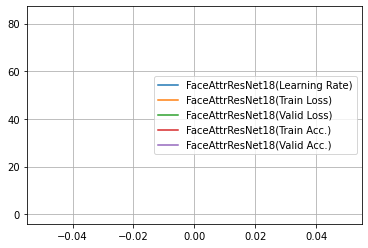

In [23]:
config.epochs = 1
logger, best_prec1, start_epoch = resume_checkpoint(model, optimizer, config.ckp_resume)
if config.evaluate:
    test_loss, prec1 = validate(dataloaders['test'], model, criterion)
    print(f"=> Best test accuracy: {prec1}, Model val acc: {best_prec1}")
else:
    trainer(dataloaders, model, criterion, optimizer, start_epoch, best_prec1)